In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')


In [2]:
cpu_load_df = pd.read_csv(
    "C:\\Jupyter_Workspace\\spoons\\5_week\\cpu_load.csv",
    parse_dates=True,
    index_col='timestamp'
    )

In [3]:
cpu_load_df

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739
...,...
2014-04-14 23:35:00,18.074649
2014-04-14 23:40:00,21.002014
2014-04-14 23:45:00,20.566713


<AxesSubplot:xlabel='timestamp'>

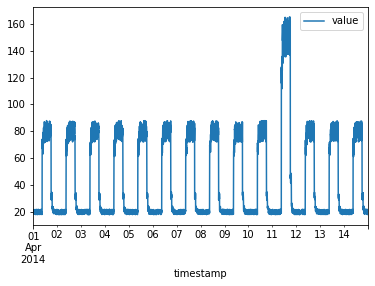

In [4]:
cpu_load_df.plot()

## 1. 정상 데이터를 구할 수 있는 경우
  1.1 말그대로 정상 샘플
  
  1.2 이상치가 포함된 데이터에서 알고 있던 이상치 (Known Anomaly)를 제거

In [5]:
cpu_load_normal_df = pd.read_csv(
    "C:\\Jupyter_Workspace\\spoons\\5_week\\cpu_load_normal.csv",
    parse_dates=True,
    index_col='timestamp'
    )

<AxesSubplot:xlabel='timestamp'>

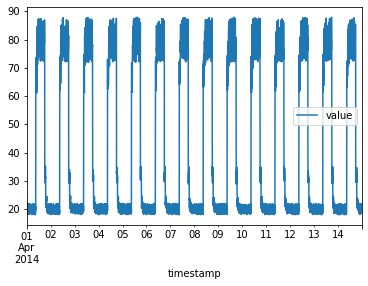

In [6]:
cpu_load_normal_df.plot()

## 데이터 전처리

In [7]:
training_mean = cpu_load_normal_df.mean()
training_std = cpu_load_normal_df.std()
df_training_value = (cpu_load_normal_df - training_mean) / training_std # z-score 정규화

## Blocked CV 형식으로 데이터 분할

In [8]:
# Blocked Crossvalidation
TIME_STEPS = 288 # 1440분 => 하루

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

# AutoEncoder, x=y
x_train = create_sequences(df_training_value.values)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
print("Training input shape: ", x_train.shape)
# 3744 => 시퀀스
# 288 => 
# 1 => 

Training input shape:  (3744, 288, 1)


In [9]:
df_training_value.shape

(4032, 1)

In [10]:
x_train.shape

(3744, 288, 1)

In [11]:
# CNN 기반 모델
model = keras.Sequential(
    [                         # 288,                1
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        # 요약한 정보를 32차원으로 바꾸고, 7개의 window를 보고, 2개 중에서 pooling을 하겠다.
        # strides => pooling 하겠다.
        # 
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu" # 144, 32
        ),
        layers.Dropout(rate=0.2),
        # 요약한 정보를 16차원으로 바꾸고, 7개의 window를 보고, 2개 중에서 pooling을 하겠다
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu" # 72, 16
        ),
        layers.Conv1D(
            filters=8, kernel_size=7, padding="same", strides=2, activation="relu" # 36, 8
        ),
        layers.Conv1D(
              filters=4, kernel_size=7, padding="same", strides=2, activation="relu" # 18, 4 <= z vector / Encoder 끝. # 입력
          ),
        # Decoder 시작
        # Conv1DTranspose =>  컨폴루션을 복원 시키는 것
        layers.Conv1DTranspose(
            filters=8, kernel_size=7, padding="same", strides=2, activation="relu" # 36, 8
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu" # 72, 16
        ),
        layers.Dropout(rate=0.2),
        # 32차원으로 7개의 윈도우를 봐서, stride=2이므로, 시계열이 2배로 확장.
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu" # 144, 32
        ),
          layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu" # 288, 32
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"), # 288, 1, 원본 시계열.
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_2 (Conv1D)           (None, 36, 8)             904       
                                                                 
 conv1d_3 (Conv1D)           (None, 18, 4)             228       
                                                                 
 conv1d_transpose (Conv1DTra  (None, 36, 8)            232       
 nspose)                                                         
                                                        

In [12]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128
)

Epoch 1/50
30/30 [==============================] - 6s 9ms/step - loss: 0.7835
Epoch 2/50
30/30 [==============================] - 0s 6ms/step - loss: 0.1889
Epoch 3/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0854
Epoch 4/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0684
Epoch 5/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0586
Epoch 6/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0514
Epoch 7/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0456
Epoch 8/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0405
Epoch 9/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0365
Epoch 10/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0337
Epoch 11/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0317
Epoch 12/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0303
Epoch 13/50
30/30 [==============================

In [13]:
x_train_pred = model.predict(x_train)

In [14]:
x_train_pred.shape

(3744, 288, 1)

## 학습 데이터를 그대로 복원  => 복원된 데이터와 학습 데이터를 비교

## 이상치 포함

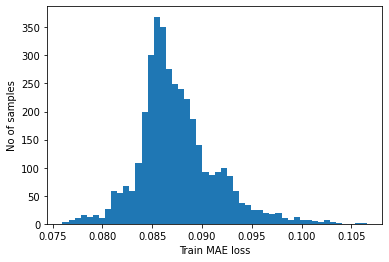

Reconstruction error threshold:  0.12784832764840987


In [15]:
x_train_pred = model.predict(x_train)
                          # 예측값 각각에 대한 mean absoulte err
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
# threshold = np.max(train_mae_loss) * 1 # 학습 데이터의 최대 에러의 95% 수준보다 넘어가는건 이상치다.
threshold = np.max(train_mae_loss) * 1.2 # 1.2를 곱한이유는 그냥 임계값을 1.2 곱해서 정하고 싶어서 이부분은 정하기 나름이다.
print("Reconstruction error threshold: ", threshold)
# Train MAE loss 그래프 분포가 정규 분포에 많이 벗어난다고 한다면 Train data로서 사용하기에는 이상 데이터가 너무 많이
# 섞여 있기때문에 좋지 않다고 볼 수 있다.

## 이상치 포함 X

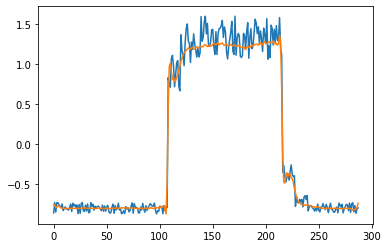

In [16]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

In [17]:
df_test_value = (cpu_load_df - training_mean) / training_std

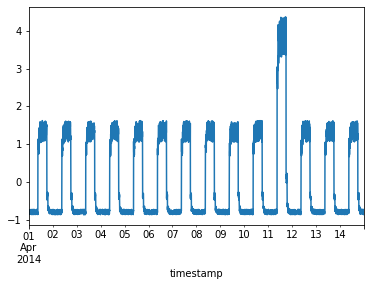

Test input shape:  (3744, 288, 1)


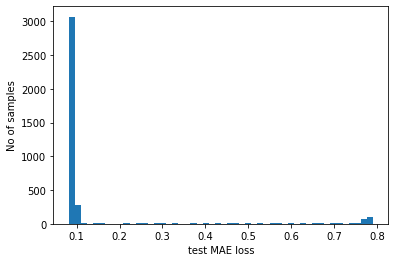

Number of anomaly samples:  393
Indices of anomaly samples:  (array([2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712,
       2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723,
       2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734,
       2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745,
       2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756,
       2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767,
       2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778,
       2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789,
       2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800,
       2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811,
       2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822,
       2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833,
       2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2

In [18]:
df_test_value = (cpu_load_df - training_mean) / training_std

fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold # 학습 데이터의 최대 로스보다 큰 로스 값 index
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [19]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

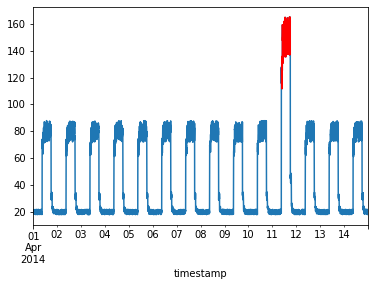

In [20]:
df_subset = cpu_load_df.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
cpu_load_df.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

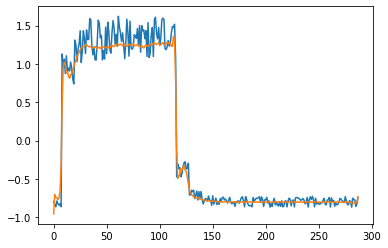

In [22]:
plt.plot(x_test[100])
plt.plot(x_test_pred[100])
plt.show()

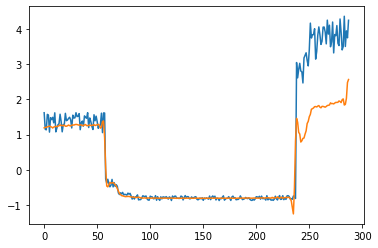

In [27]:
plt.plot(x_test[2750])
plt.plot(x_test_pred[2750])
plt.show()

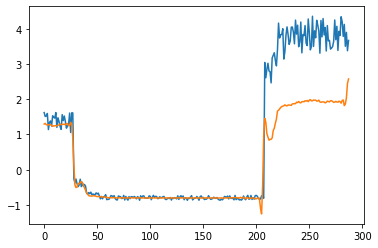

In [28]:
plt.plot(x_test[2780])
plt.plot(x_test_pred[2780])
plt.show()

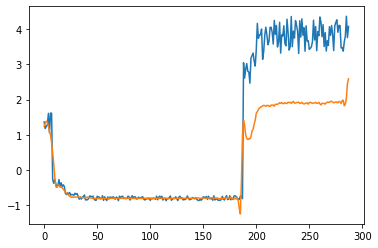

In [29]:
plt.plot(x_test[2800])
plt.plot(x_test_pred[2800])
plt.show()

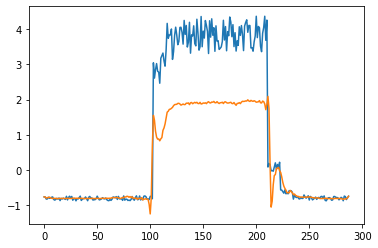

In [23]:
plt.plot(x_test[2885])
plt.plot(x_test_pred[2885])
plt.show()